In this notebook we solve the linearized Navier–Stokes equations,

$$
\partial_t u - \varepsilon \Delta u + (w\cdot\nabla)u - \nabla p = f,
\qquad
\nabla\cdot u = 0,
$$

using a fully space–time finite element formulation.  
The corresponding weak form reads

$$
(u_t, v)_\Omega
+ (\nabla u, \nabla v)_\Omega
+ (w\cdot\nabla u, v)_\Omega
+ (\nabla\cdot u, q)_\Omega
+ (p, \nabla\cdot v)_\Omega
= (f, v)_\Omega + (g, q)_\Omega.
$$

In contrast to the previous notebook, we use a Taylor–Hood pairing, that is  
**$[P_2]^3$ for the velocity and $P_1$ for the pressure**, which is known to satisfy the LBB (inf–sup) condition and is therefore stable without additional pressure stabilization.


In [38]:
from import_hack import *
from methodsnm.mesh_4d import *
from methodsnm.visualize import *
import math
import numpy as np
from numpy import exp
from methodsnm.vectorspace import *
from methodsnm.fes import *
from netgen.csg import unit_cube
from ngsolve import Mesh,VOL,specialcf
#from methodsnm.forms import *

In [39]:
def list_diff(a, b):
    """Entfernt alle Elemente aus Liste a, die in Liste b enthalten sind."""
    return [x for x in a if x not in b]

In [40]:

m = 2
T = 2
epsi = 0.1
ngmesh = Mesh(unit_cube.GenerateMesh(maxh=0.5))
mesh = UnstructuredHypertriangleMesh(T,ngmesh)
mesh = UnstructuredHypertriangleMesh(T,ngmesh)
V1 = P2_Hypertriangle_Space(mesh)
V2 = P2_Hypertriangle_Space(mesh)
V3 = P2_Hypertriangle_Space(mesh)
Q = P1_Hypertriangle_Space(mesh)
Fes = Productspace([V1,V2,V3,Q])
print("DOF für den P1_space:",Q.ndof,"DOF für den P2_space:", V1.ndof)
print(Fes.ndof , Fes.offsets)

DOF für den P1_space: 78 DOF für den P2_space: 652
2034 [0, 652, 1304, 1956, 2034]


We define an analytival divergencefree solution and a corresponding right handside. 

In [41]:
nu = 1
wx, wy, wz = 1, 1, 1
NU = GlobalFunction(lambda x: nu, mesh = mesh)
w = ConstantVectorFunction(np.array([wx,wy,wz,1]), mesh = mesh)

uex1 = lambda x: np.exp(-x[3]) * np.sin(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
uex2 = lambda x: -np.exp(-x[3]) * np.cos(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[2])
uex3 = lambda x: 0.0
#pex  = lambda x: np.exp(-x[3]) * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.sin(np.pi * x[2])
pex  = lambda x: 0.0
f1 = lambda x: np.exp(-x[3]) * (
    (-1.0 + 3.0 * (np.pi**2) * nu) * np.sin(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
    + np.pi * wx * np.cos(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
    - np.pi * wy * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[2])
    - np.pi * wz * np.sin(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.sin(np.pi * x[2])
    #- np.pi * np.sin(np.pi * x[1]) * np.sin(np.pi * x[2]) * np.cos(np.pi * x[0])   # <--- Vorzeichen gedreht
)

f2 = lambda x: np.exp(-x[3]) * (
    (1.0 - 3.0 * (np.pi**2) * nu) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[0]) * np.cos(np.pi * x[2])
    + np.pi * wx * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.cos(np.pi * x[2])
    - np.pi * wy * np.cos(np.pi * x[0]) * np.cos(np.pi * x[1]) * np.cos(np.pi * x[2])
    + np.pi * wz * np.sin(np.pi * x[1]) * np.sin(np.pi * x[2]) * np.cos(np.pi * x[0])
    #- np.pi * np.sin(np.pi * x[0]) * np.sin(np.pi * x[2]) * np.cos(np.pi * x[1])   # <--- Vorzeichen gedreht
)

f3 = lambda x: 0.0
g = lambda x: 0.0

fx = GlobalFunction(f1, mesh = mesh)
fy = GlobalFunction(f2, mesh = mesh)
fz = GlobalFunction(f3, mesh = mesh)
g = GlobalFunction(g, mesh = mesh)



In [42]:
from methodsnm.forms import *
from methodsnm.formint import *
BF = BilinearVectorForm(Fes)
c = ConstantFunction(0.0000001 ,mesh = mesh)

for b in range(3):
    BF.add_block_integrator(b, b, LaplaceIntegral_without_time(NU))
    BF.add_block_integrator(b, b, ConvectionIntegral(w))
for b in range(3):
    BF.add_block_integrator(3, b, DivUQIntegrator())
    BF.add_block_integrator(b, 3, DivVPIntegrator())
BF.add_block_integrator(3, 3, MassIntegral(c)) #to avoid singular matrix
BF.assemble()

LF = LinearVectorForm(Fes)
LF.add_block_integrator(0, SourceIntegral(fx))
LF.add_block_integrator(1, SourceIntegral(fy))
LF.add_block_integrator(2, SourceIntegral(fz))
LF.add_block_integrator(3, SourceIntegral(g))
LF.assemble()


Since we now work with $P_2$ elements, the finite element space has a different structure, including both vertex and edge degrees of freedom.  
Nevertheless, the implementation still provides convenient functions to access the boundary vertices, allowing us to impose Dirichlet conditions in the same way as before.


In [43]:
top = mesh.top_bndry_vertices
initial = mesh.initial_bndry_vertices
bndry = V1.boundary_dofs_excluding_top()
freedofs = [d for d in range(V1.ndof) if d not in bndry]


In [44]:
u = FEVectorFunction(Fes)
u._set_P2({0: (uex1,bndry), 1: (uex2,bndry), 2: (uex3,bndry)})


res = LF.vector - BF.matrix.dot(u.vector)
freedofs_global = Fes.get_freedofs({0: bndry, 1: bndry, 2: bndry})
from methodsnm.solver import solve_on_freedofs
u.vector += solve_on_freedofs(BF.matrix,res,freedofs_global)
u1 , u2, u3 , p = u.blocks()

from methodsnm.forms import compute_difference_L2
u_ex1 = GlobalFunction(uex1, mesh = mesh)
u_ex2 = GlobalFunction(uex2, mesh = mesh)
u_ex3 = GlobalFunction(uex3, mesh = mesh)
l2diff1 = compute_difference_L2(u1, u_ex1, mesh, intorder = 5)
print("L2 difference u1:", l2diff1)
l2diff2 = compute_difference_L2(u2, u_ex2, mesh, intorder = 5)
print("L2 difference u2:", l2diff2)
l2diff3 = compute_difference_L2(u3, u_ex3, mesh, intorder = 5)
print("L2 difference u3:", l2diff3)

L2 difference u1: 0.09809258788549148
L2 difference u2: 0.0922736034471687
L2 difference u3: 0.07989137333148509


Testing if the set method is working fine.

In [45]:
u = FEVectorFunction(Fes)
u._set_P2({0:uex1, 1:uex2, 2:uex3})
u1 ,u2 ,u3 , p = u.blocks()
print(compute_difference_L2(u1, u_ex1, mesh, intorder = 5), compute_difference_L2(u2, u_ex2, mesh, intorder = 5), compute_difference_L2(u3, u_ex3, mesh, intorder = 5))

0.03375167857723526 0.035282572606294395 0.0


shape: (2034, 2034)
nnz  : 128894


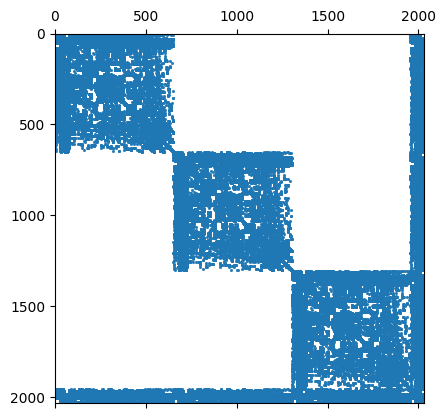

In [46]:
from scipy.sparse.linalg import spsolve
K = BF.matrix
rows, cols = K.nonzero()      
nnz = K.nnz                    

print("shape:", K.shape)
print("nnz  :", nnz)

#Sparsity-Plot
plt.figure()
plt.spy(K, markersize=1)
plt.show()


From the sparsity pattern we can again clearly identify the individual blocks of the system matrix.  
However, it immediately becomes apparent that, for the same mesh size and number of time steps, the total number of degrees of freedom is significantly larger.  
This is expected, since each $P_2$ element introduces 10 additional local DOFs compared to linear elements.
